In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import numpy as np
import scipy
from scipy.interpolate import RegularGridInterpolator

import yaml
from tqdm import tqdm 

import os

import matplotlib.pyplot as plt
from neurorient.model import NeurOrient, NeurOrientLightning
from neurorient.utils_visualization import save_mrc, display_volumes, display_fsc, display_images
from neurorient.reconstruction.phasing import PhaseRetriever
from neurorient.metrics import compute_fsc
from neurorient.reconstruction.slicing import real_mesh_2_reciprocal_mesh

from sklearn.model_selection import train_test_split

import skopi as sk
import h5py
from pytorch3d.transforms import (
    matrix_to_quaternion, quaternion_to_matrix, so3_rotation_angle, so3_relative_angle,
    matrix_to_axis_angle
    )

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:76: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_phase(atom_pos, q_xyz):
/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/skopi/diffraction.py:90: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def cal(f_hkl, atom_pos, q_xyz, xyz_ind, pixel_number):
/pscratch/sd/z

In [3]:
with open('/pscratch/sd/z/zhantao/neurorient_repo/experiments/experiments.yaml') as f:
    experiments = yaml.safe_load(f)

In [4]:
experiments['1bxr']

{'resnet18': {'f1_p1_g1_b1_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755838/checkpoints/1BXR-epoch=532-step=15430.ckpt',
  'f1_p1_g1_b0_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755837/checkpoints/1BXR-epoch=634-step=18390.ckpt',
  'f1_p1_g1_b0_c0': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755836/checkpoints/1BXR-epoch=840-step=24370.ckpt',
  'f1_p1_g0_b0_c0': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755834/checkpoints/1BXR-epoch=896-step=25990.ckpt'},
 'bifpn18': {'f1_p1_g1_b1_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755810/checkpoints/1BXR-epoch=842-step=24420.ckpt',
  'f1_p1_g1_b0_c1': '/pscratch/sd/z/zhantao/neurorient_repo/experiments/transformations/lightning_logs/version_16755812/checkpoints/1BXR-epoch=891-step

In [5]:
pdb = '1BXR'
poisson = True
num_images = 10000
increase_factor = 10

In [52]:
spi_data = torch.load(f'/pscratch/sd/z/zhantao/neurorient_repo/data/{pdb}_increase{increase_factor:d}_poisson{poisson}_num{num_images//1000:d}K.pt')
ckpt_path = experiments[pdb.lower()]['resnet18']['f1_p1_g1_b0_c0']
save_dir = '/pscratch/sd/z/zhantao/neurorient_repo/data'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [53]:
model = NeurOrientLightning.load_from_checkpoint(ckpt_path)

In [54]:
model.to(device)

grid_reciprocal = np.pi * model.model.grid_position_reciprocal / model.model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.model.predict_intensity(grid_reciprocal.to(device))
intensity_pred = (torch.exp(intensity) - 1).cpu().numpy() / model.model.loss_scale_factor

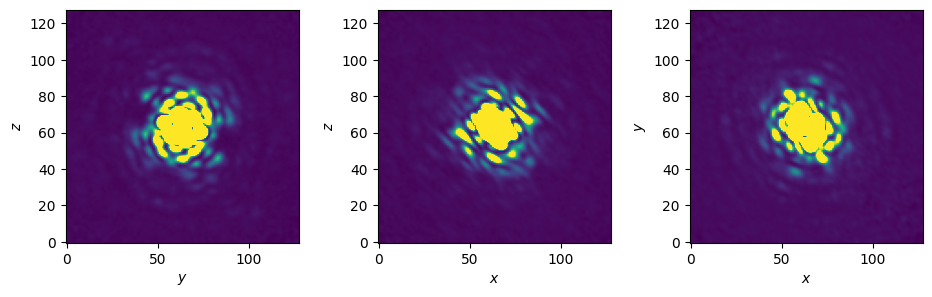

In [55]:
display_volumes(intensity_pred - intensity_pred.min(), closefig=False, vmax=1e-3 * intensity_pred.max())

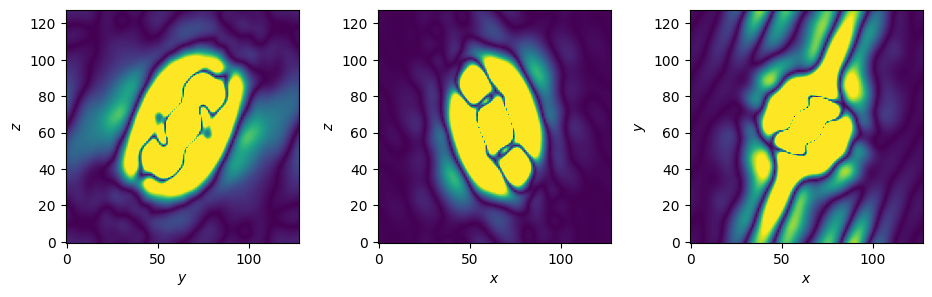

In [31]:
ac_pred = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(torch.from_numpy(intensity_pred))).abs())
display_volumes(ac_pred, closefig=False, vmin=0, vmax=1e-2 * ac_pred.max())

In [32]:
intensity_true = spi_data['volume'].abs()

In [33]:
phase_retriever = PhaseRetriever(n_phase_loops=300, beta_HIO=0.3, beta_DM=0.3, shrink_wrap_method='max')
rho_phased_from_true, support_phased_from_true = phase_retriever.phase(intensity_true.to(device))
display_volumes(rho_phased_from_true, closefig=False, vmin=0)
# save_mrc(f'{pdb}_pr.mrc', rho_phased.detach().cpu().numpy())

Phase Retrieval:   5%|▌         | 15/300 [00:03<01:14,  3.81it/s]


KeyboardInterrupt: 

Phase Retrieval: 100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


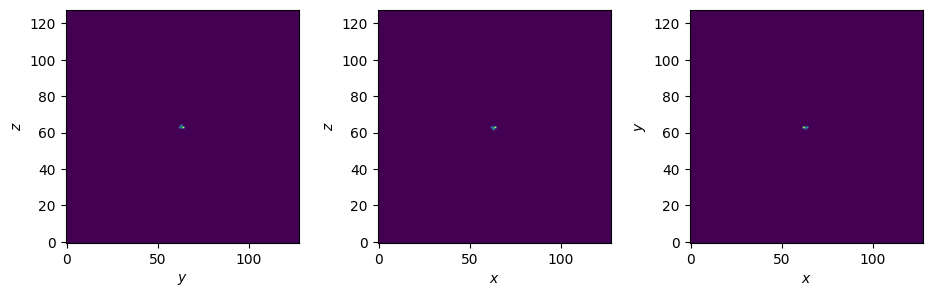

In [34]:
phase_retriever = PhaseRetriever(n_phase_loops=100, beta_HIO=0.3, beta_DM=0.3, shrink_wrap_method='max')
# rho_phased, support_phased = phase_retriever.phase(torch.from_numpy(intensity_pred.clip(intensity_pred.max() * 1e-5)).sqrt().to(device))
rho_phased, support_phased = phase_retriever.phase(torch.from_numpy(intensity_pred - intensity_pred.min()).sqrt().to(device))
display_volumes(rho_phased, closefig=False, vmin=0)
# save_mrc(f'{pdb}_pr.mrc', rho_phased.detach().cpu().numpy())

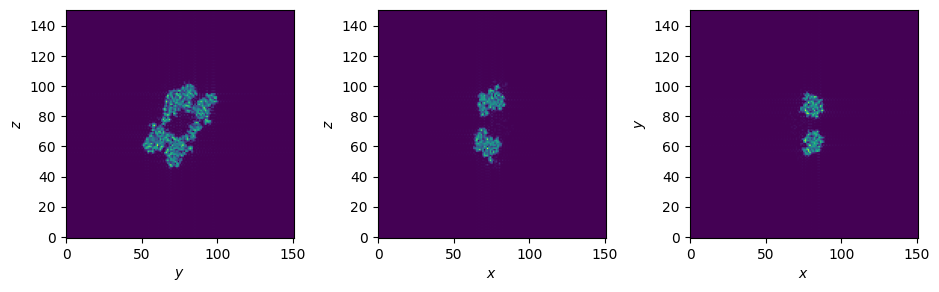

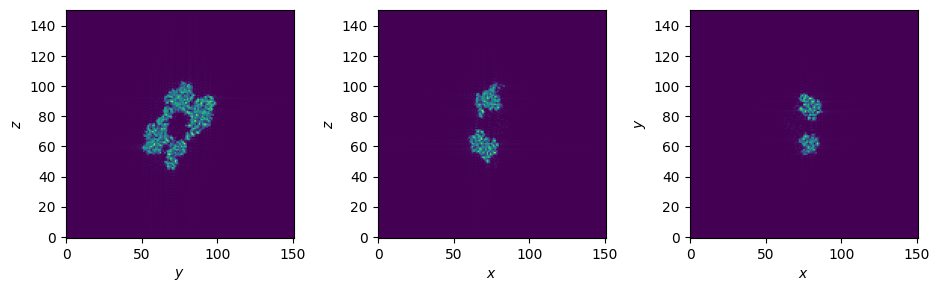

In [13]:
from neurorient.reconstruction.phasing import recenter

real_volume = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(spi_data['volume'])).real).clamp(0.)
display_volumes(real_volume, closefig=False)
real_volume = torch.fft.fftshift(recenter(
    torch.fft.ifftshift(real_volume), torch.ones_like(real_volume), M=real_volume.shape[-1]
)[0])
display_volumes(real_volume, closefig=False)

In [109]:
rho_cc, qshell, fsc, opt_q = compute_fsc(
    rho_phased_from_true,
    spi_data['vol_real_mesh'],
    real_volume, 
    spi_data['vol_real_mesh'], 
    volume_type='electron_density',
    align_zoom=0.3,
    align_n_search=1000)

NameError: name 'rho_phased_from_true' is not defined

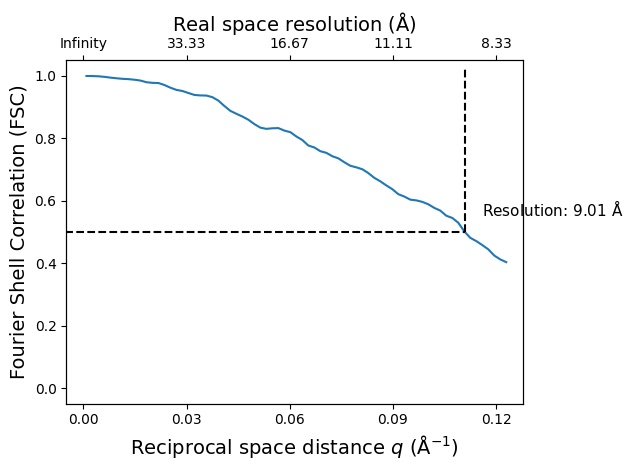

In [35]:
display_fsc(qshell, fsc, resolution=rho_cc, closefig=False)

In [35]:
rho_cc, qshell, fsc, opt_q = compute_fsc(
    rho_phased,
    model.model.grid_position_real,
    real_volume, 
    spi_data['vol_real_mesh'], 
    volume_type='electron_density',
    align_zoom=0.3,
    align_n_search=1000)

Initial CC between unzoomed / unfiltered volumes is: 0.001
Alignment CC after rotation is: 0.027
Map had to be inverted
Final CC between unzoomed / unfiltered volumes is: 0.001
Estimated resolution from FSC: 156.3 Angstrom


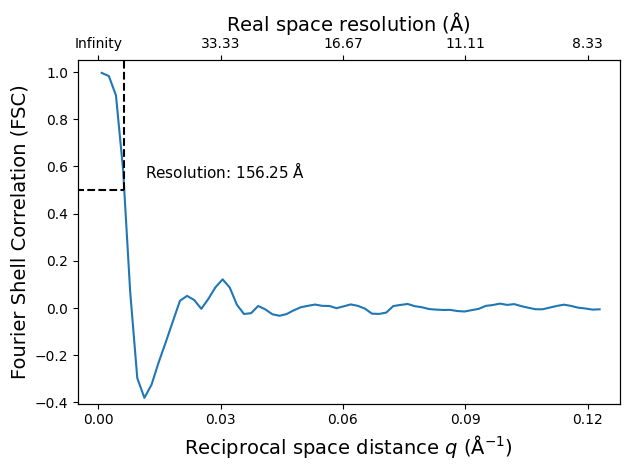

In [36]:
display_fsc(qshell, fsc, resolution=rho_cc, closefig=False)

Initial CC between unzoomed / unfiltered volumes is: 0.486
Alignment CC after rotation is: 0.765
Final CC between unzoomed / unfiltered volumes is: 0.584
Estimated resolution from largest-q: at least 11.4 Angstrom


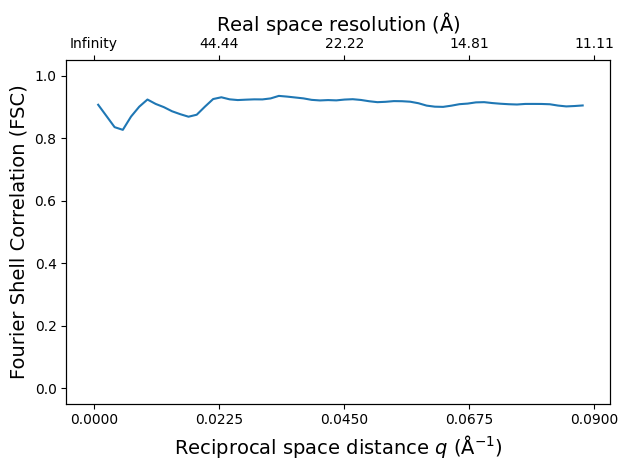

In [37]:
resolution, qshell, fsc, opt_q = compute_fsc(
    intensity_pred/intensity_pred.max(),
    model.model.grid_position_reciprocal,
    spi_data['volume'].abs().pow(2) / spi_data['volume'].abs().pow(2).max(),
    real_mesh_2_reciprocal_mesh(spi_data['vol_real_mesh']), 
    volume_type='intensity')
display_fsc(qshell, fsc, closefig=False)

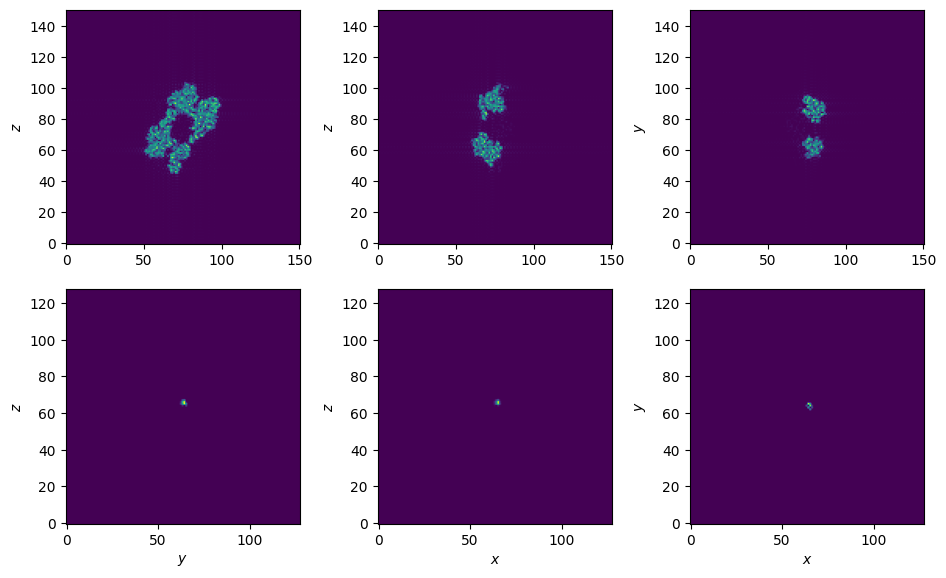

In [38]:
from neurorient.external.spinifel import rotate_volume

rot_rho_phased = rotate_volume(
    rho_phased.detach().cpu().numpy(), 
    np.array([[opt_q.get()[0], opt_q.get()[1], opt_q.get()[2], opt_q.get()[3]]]))[0]
display_volumes([real_volume, rot_rho_phased], closefig=False)

In [39]:
opt_R = quaternion_to_matrix(torch.from_numpy(opt_q.get()))
opt_R_sk = torch.from_numpy(sk.geometry.quaternion2rot3d(opt_q.get()))

In [40]:
slice_dataset = TensorDataset(spi_data['intensities'].unsqueeze(1))
quat_dataset = TensorDataset(spi_data['orientations'])

train_idx, val_test_idx = train_test_split(np.arange(len(slice_dataset)), test_size=1/10, random_state=42)
val_idx, test_idx = train_test_split(val_test_idx, test_size=1/2, random_state=42)

complete_slice_loader = DataLoader(slice_dataset, batch_size=100, shuffle=False)
complete_quat_loader = DataLoader(quat_dataset, batch_size=100, shuffle=False)

# train_slice_loader = DataLoader([slice_dataset[i] for i in train_idx], batch_size=100, shuffle=False)
# train_quat_loader = DataLoader([quat_dataset[i] for i in train_idx], batch_size=100, shuffle=False)

# val_slice_loader = DataLoader([slice_dataset[i] for i in val_idx], batch_size=100, shuffle=False)

# test_slice_loader = DataLoader([slice_dataset[i] for i in test_idx], batch_size=100, shuffle=False)
# test_quat_loader = DataLoader([quat_dataset[i] for i in test_idx], batch_size=100, shuffle=False)

In [41]:
orientations = []
true_matrix = []
with torch.no_grad():
    for (batch_slice, batch_quat) in tqdm(zip(complete_slice_loader, complete_quat_loader), 
                                          total=len(complete_slice_loader)):
        _orientations, slices_pred = model.model.estimate(batch_slice[0].to(device), return_reconstruction=True)
        orientations.append(_orientations.detach().cpu())
        true_matrix.append(quaternion_to_matrix(batch_quat[0].to(device)).detach().cpu())
orientations = torch.cat(orientations)
true_matrix = torch.cat(true_matrix)

100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


In [42]:
rot_orientations = torch.einsum("lij, kj -> lik", orientations, opt_R.to(orientations))
# rot_orientations = torch.einsum("kj, lji -> lik", opt_R.to(orientations), orientations)

In [43]:
from neurorient.utils_transform import NUFFT

In [44]:
nufft = NUFFT(spi_data['pixel_position_reciprocal'], device=device)

In [45]:
import torch

def rotation_matrix(axis, angle):
    """
    Generate a rotation matrix for a given axis and angle.
    """
    c = torch.cos(angle)
    s = torch.sin(angle)
    if axis == 'x':
        return torch.tensor([
            [1, 0, 0],
            [0, c, -s],
            [0, s, c]
        ])
    elif axis == 'y':
        return torch.tensor([
            [c, 0, s],
            [0, 1, 0],
            [-s, 0, c]
        ])
    elif axis == 'z':
        return torch.tensor([
            [c, -s, 0],
            [s, c, 0],
            [0, 0, 1]
        ])
    else:
        raise ValueError(f"Unknown axis {axis}")

def construct_tensors():
    pi = torch.tensor(3.141592653589793)  # Define pi
    
    # Rotation matrices for x, y, z axes and their inversions
    matrices = [
        rotation_matrix('x', pi),
        rotation_matrix('y', pi),
        rotation_matrix('z', pi),
    ]

    # Rotation matrices for the diagonals (these are approximations for simplicity)
    matrices += [
        rotation_matrix('x', pi/2) @ rotation_matrix('y', pi/2),
        rotation_matrix('x', -pi/2) @ rotation_matrix('y', -pi/2),
        rotation_matrix('x', pi/2) @ rotation_matrix('z', pi/2),
        rotation_matrix('x', -pi/2) @ rotation_matrix('z', -pi/2),
        rotation_matrix('y', -pi/2) @ rotation_matrix('z', -pi/2)
    ]

    matrices += [torch.eye(3)]
    # Combine all rotation matrices into an Nx3x3 tensor
    tensor = torch.stack(matrices, dim=0)
    
    return tensor

# rotations = construct_tensors()
# print(rotations)


In [46]:
relative_angles = []
for _rotmat in construct_tensors():
    rot_true_matrix = torch.einsum("ij, ljk -> lik", _rotmat.to(true_matrix), true_matrix)
    relative_angles.append(so3_relative_angle(rot_orientations, rot_true_matrix))
relative_angles = torch.stack(relative_angles, dim=0)
relative_angles = torch.where(relative_angles > np.pi/2, np.pi - relative_angles, relative_angles)
# relative_angles = torch.where(relative_angles > np.pi/2, relative_angles, np.pi - relative_angles)

min_relative_angles = relative_angles.min(dim=0).values.numpy()

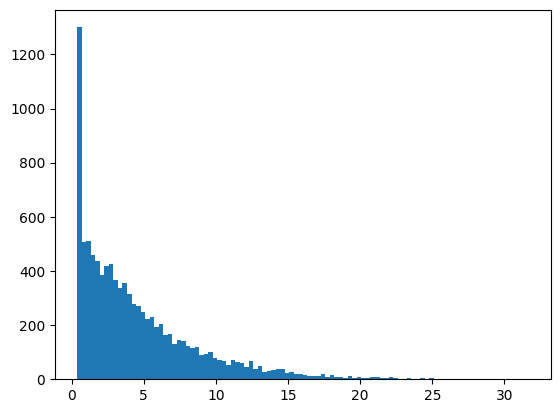

In [47]:
plt.hist(relative_angles.min(dim=0).values * 180 / np.pi, bins=100);
# plt.xlim([0, 180])

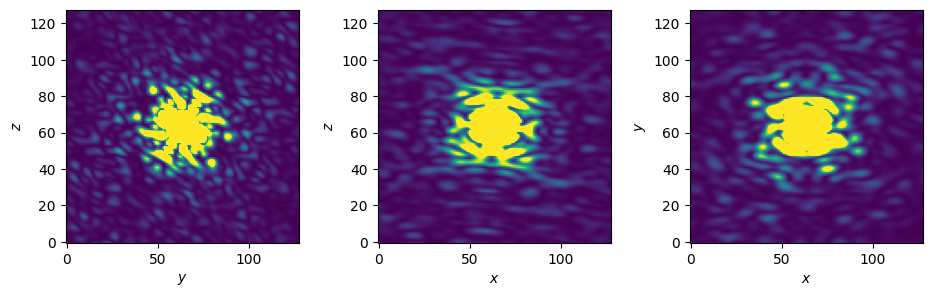

In [55]:
vol_recp_mesh = real_mesh_2_reciprocal_mesh(spi_data['vol_real_mesh']).cpu().numpy()
img_recp_mesh = real_mesh_2_reciprocal_mesh(spi_data['img_real_mesh']).cpu().numpy()

f_intensity = RegularGridInterpolator(
    [vol_recp_mesh[:,0,0,0],
     vol_recp_mesh[0,:,0,1],
     vol_recp_mesh[0,0,:,2]], 
    spi_data['volume'].abs().pow(2).cpu().numpy())
intensity = f_intensity(img_recp_mesh)
display_volumes(intensity, closefig=False, vmin=0, vmax=1e-3 * intensity.max())

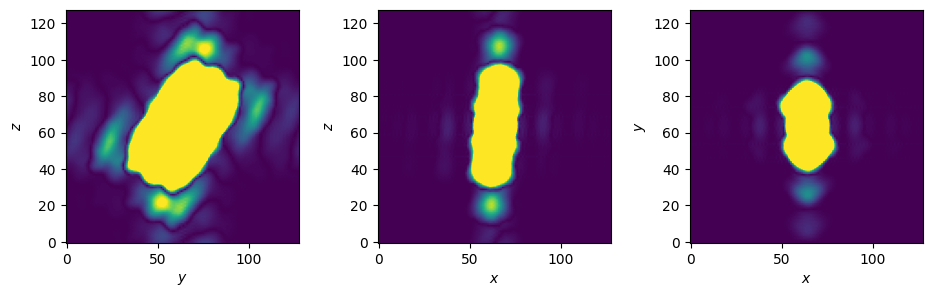

In [56]:
ac = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(torch.from_numpy(intensity))).abs())
display_volumes(ac, closefig=False, vmin=0, vmax=1e-2 * ac.max())

In [57]:
rot_ac_pred = rotate_volume(ac_pred, opt_q[None])[0]

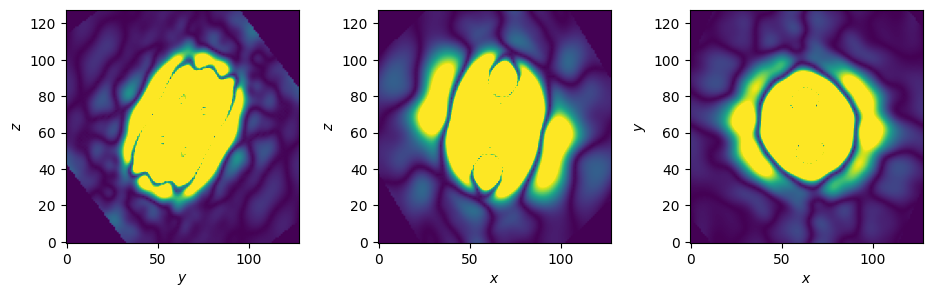

In [58]:
display_volumes(rot_ac_pred, closefig=False, vmin=0, vmax=1e-2 * ac_pred.max())

In [59]:
# nufft = NUFFT(spi_data['pixel_position_reciprocal'], device=device)

In [60]:
# rot_orientations = torch.einsum("lij, jk -> lik", orientations.permute(0,2,1), opt_R.to(orientations).permute(1,0))
_rot_orientations = torch.einsum("lij, kj -> lik", orientations, opt_R.to(orientations))

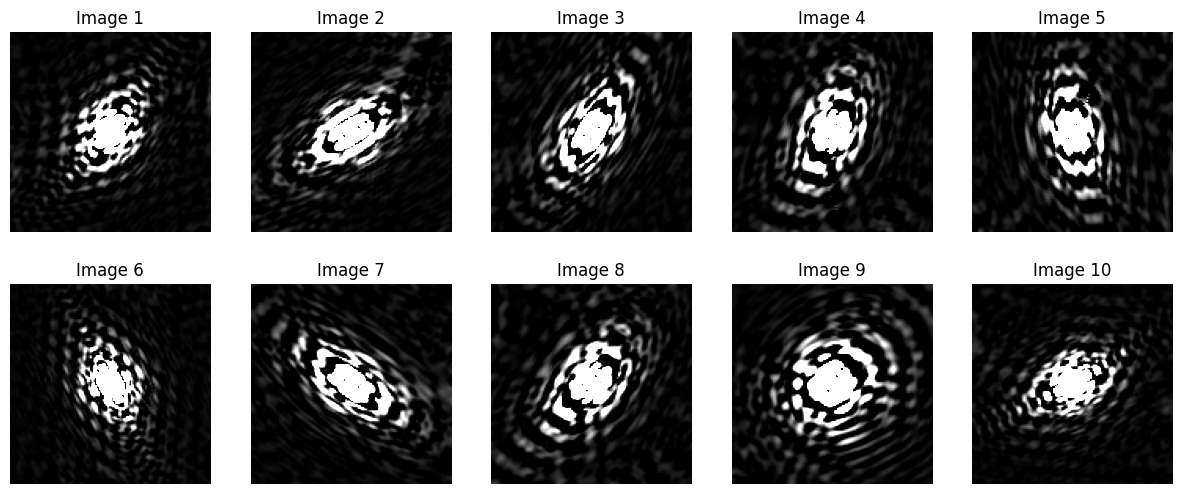

In [61]:
slices_nufft = nufft(ac_pred, orientations[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

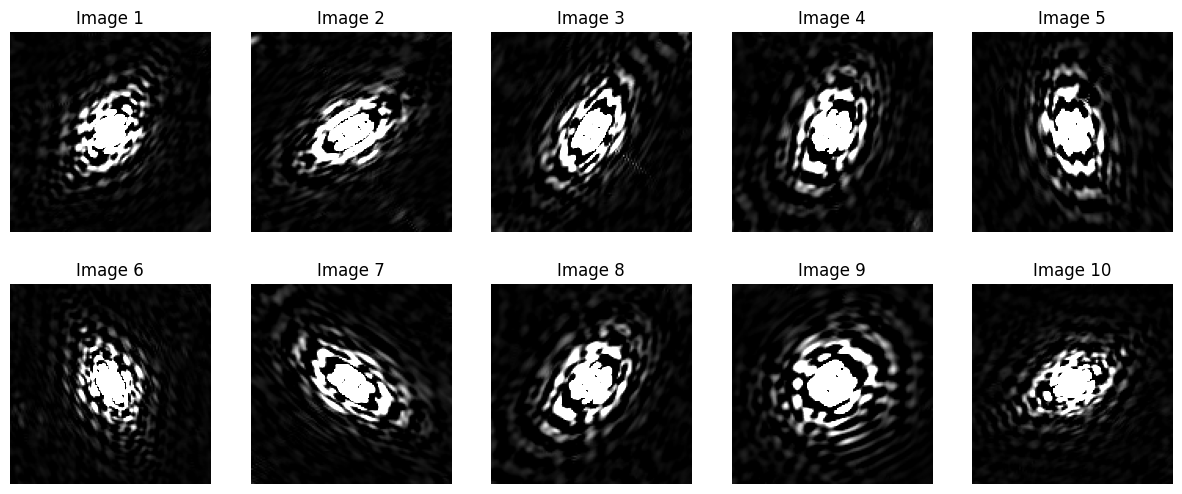

In [62]:
# _rot_orientations = torch.einsum("ji, ljk -> lik", opt_R.to(orientations), orientations)
# _rot_orientations = torch.einsum("lij, jk -> lik", orientations, opt_R.to(orientations))
_rot_orientations = torch.einsum("lij, kj -> lik", orientations, opt_R.to(orientations))
slices_nufft = nufft(rot_ac_pred, _rot_orientations[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

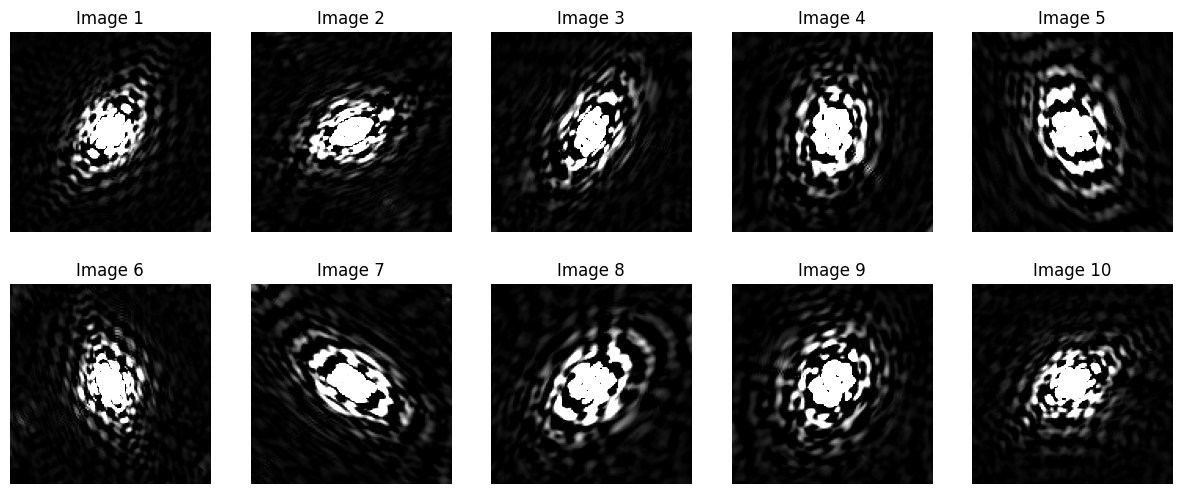

In [63]:
# rot_true_matrix = torch.einsum("lij, jk -> lik", true_matrix, opt_R.to(true_matrix))
# rot_true_matrix = torch.einsum("ij, ljk -> lik", opt_R.to(true_matrix), true_matrix)
slices_nufft = nufft(rot_ac_pred, true_matrix[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

In [64]:
rot_ac = rotate_volume(ac, matrix_to_quaternion(opt_R.T)[None])[0]

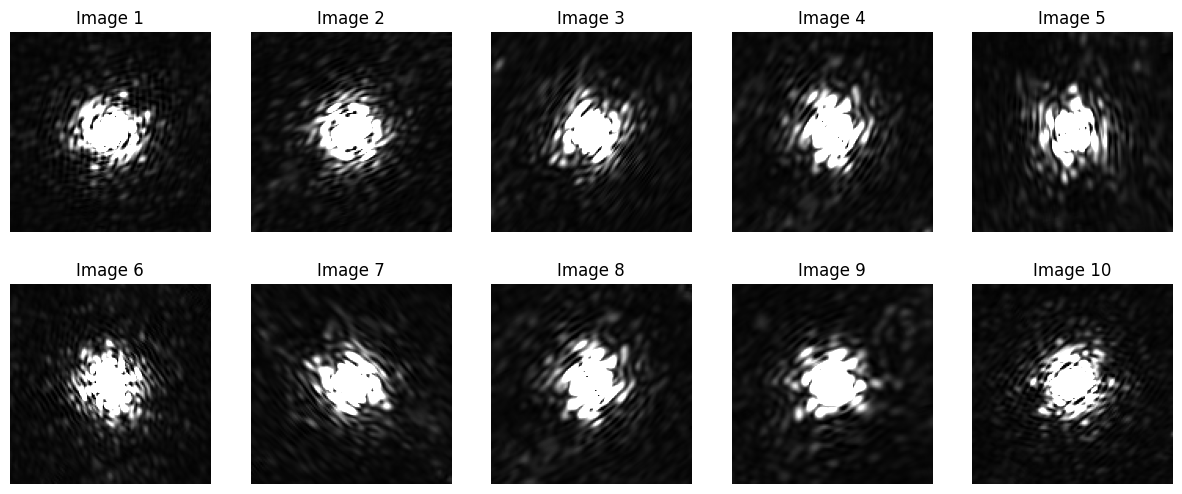

In [65]:
slices_nufft = nufft(rot_ac, orientations[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

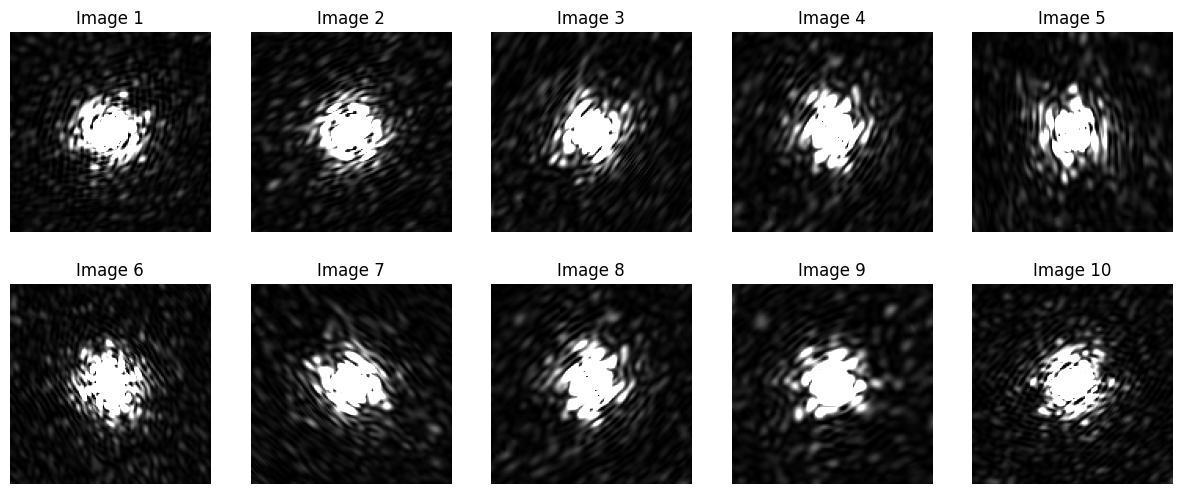

In [66]:
slices_nufft = nufft(ac, _rot_orientations[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

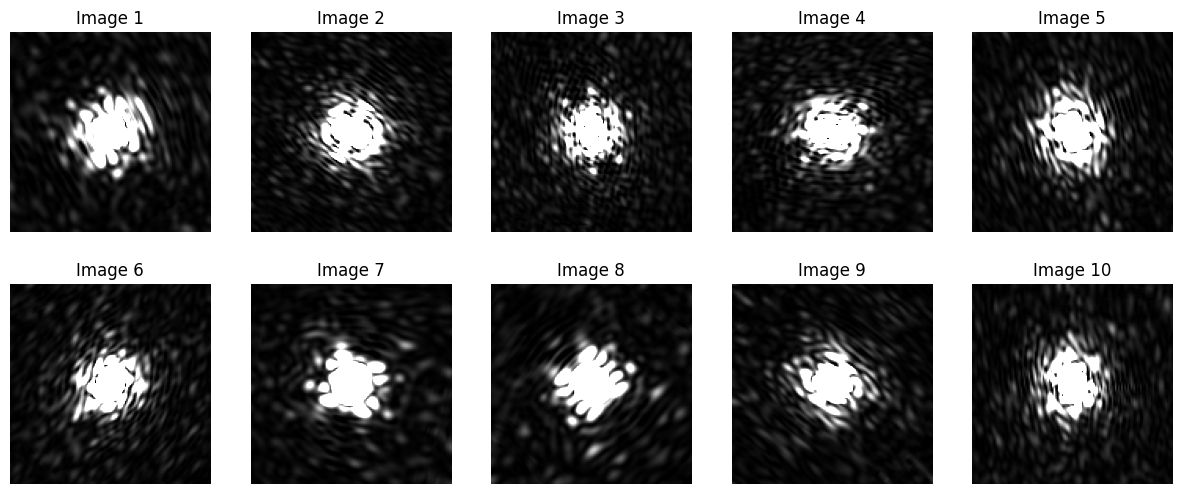

In [214]:
slices_nufft = nufft(ac, true_matrix[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

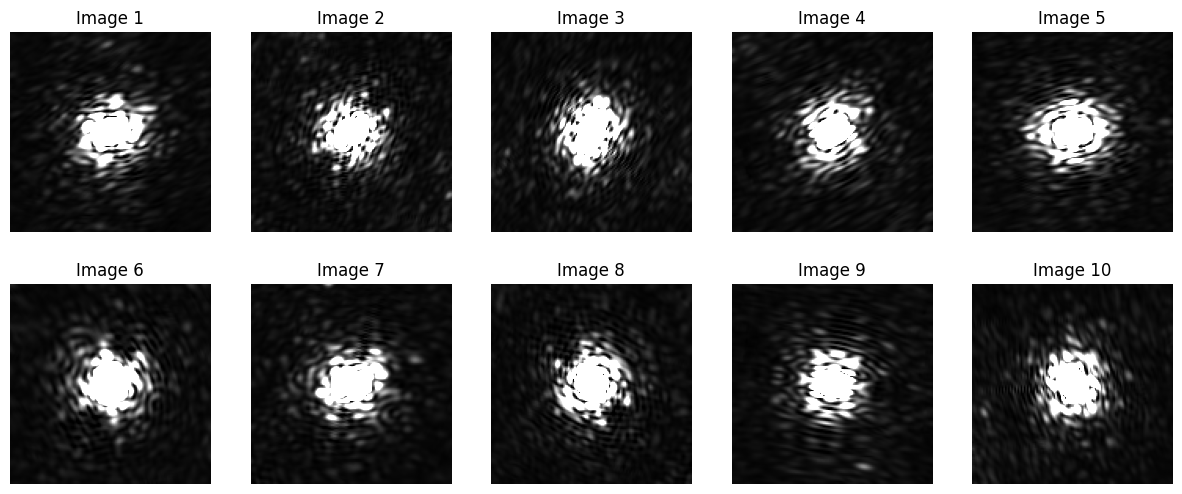

In [213]:
_rot_ac = rotate_volume(ac, matrix_to_quaternion(opt_R)[None])[0]
_rot_true_matrix = torch.einsum("ij, ljk -> lik", opt_R.T.to(orientations), true_matrix)
slices_nufft = nufft(_rot_ac, _rot_true_matrix[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

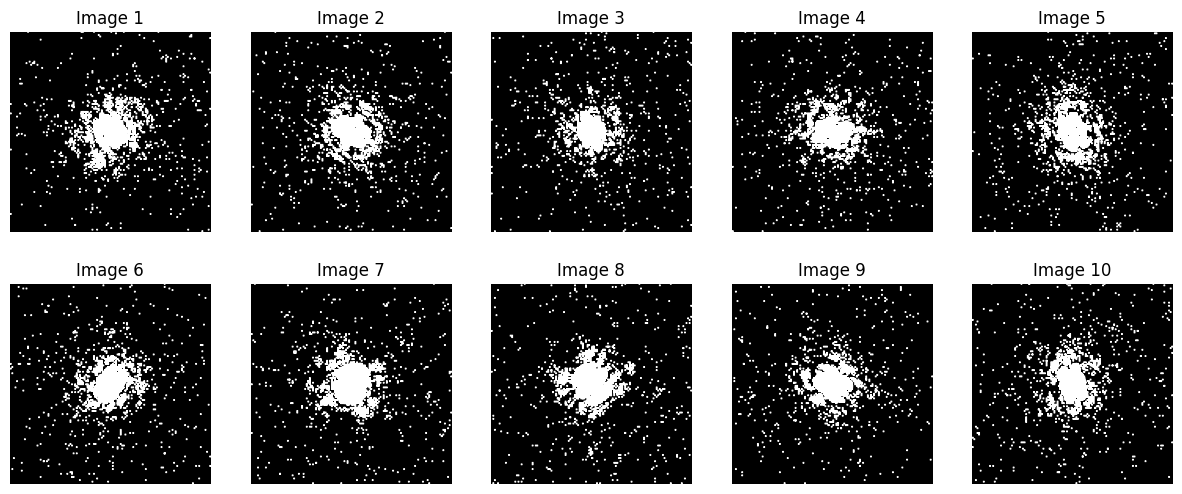

In [62]:
display_images(spi_data['intensities'][test_idx[:10]], columns=5, vmax=1e-3 * spi_data['intensities'][:10].max())

In [156]:
# To rotate about the x-axis by 90 degrees:
angle = 45 / 180 * np.pi
quat = sk.angle_axis_to_quaternion('z', angle)
print(quat)

[0.92387953 0.         0.         0.38268343]


using new version of rotate_volume


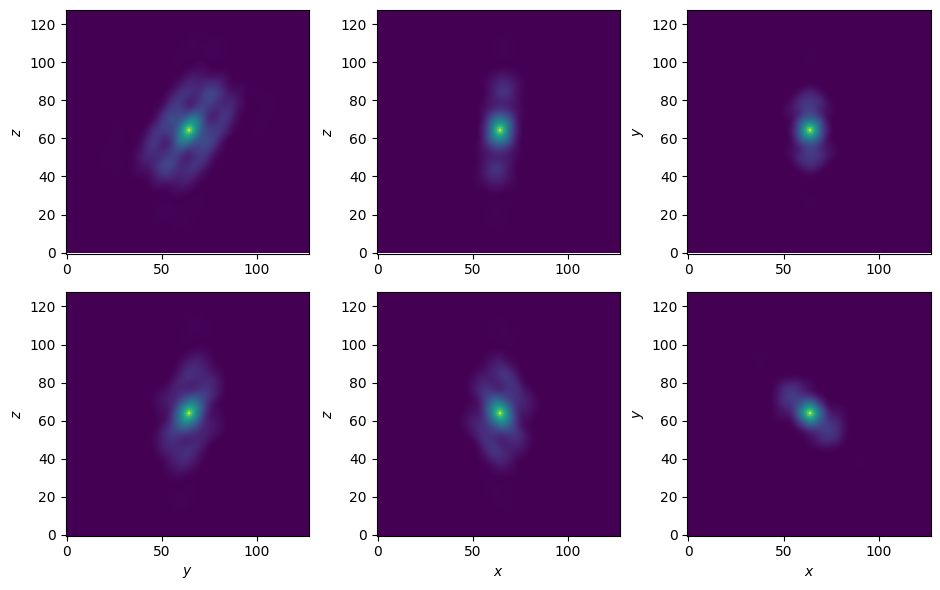

In [157]:
_rot_ac = rotate_volume(ac, quat[None])[0]
display_volumes([ac, _rot_ac], closefig=False)

In [206]:
angle = 45 / 180 * np.pi
_opt_R = torch.from_numpy(sk.angle_axis_to_rot3d('x', angle))

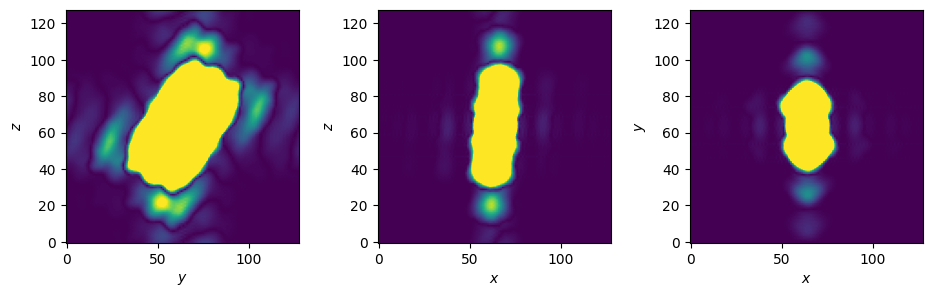

In [209]:
display_volumes(ac, closefig=False, vmin=0, vmax=1e-2 * ac.max())

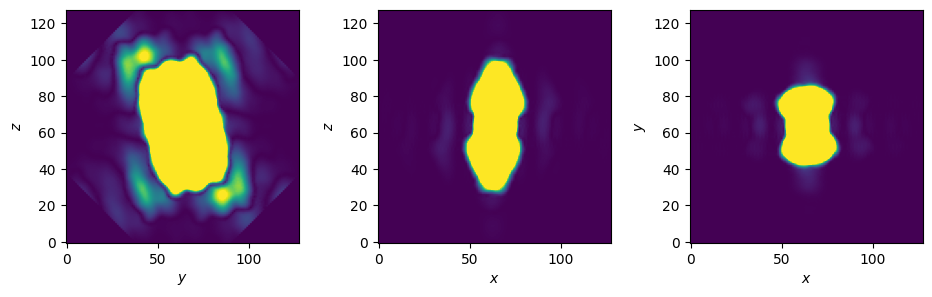

In [212]:
_rot_ac = rotate_volume(ac, matrix_to_quaternion(_opt_R)[None])[0]
display_volumes(_rot_ac, closefig=False, vmin=0, vmax=1e-2 * _rot_ac.max())

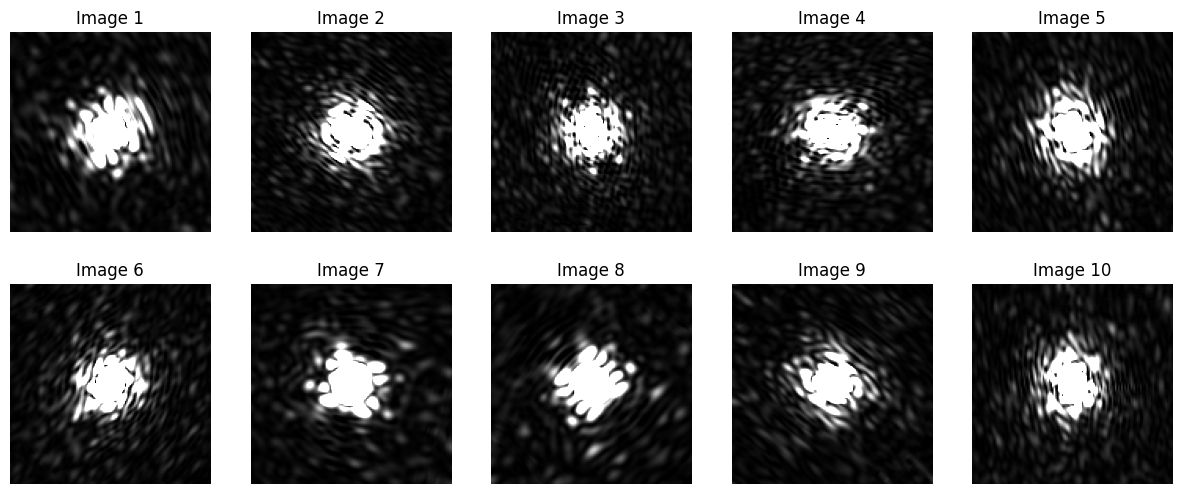

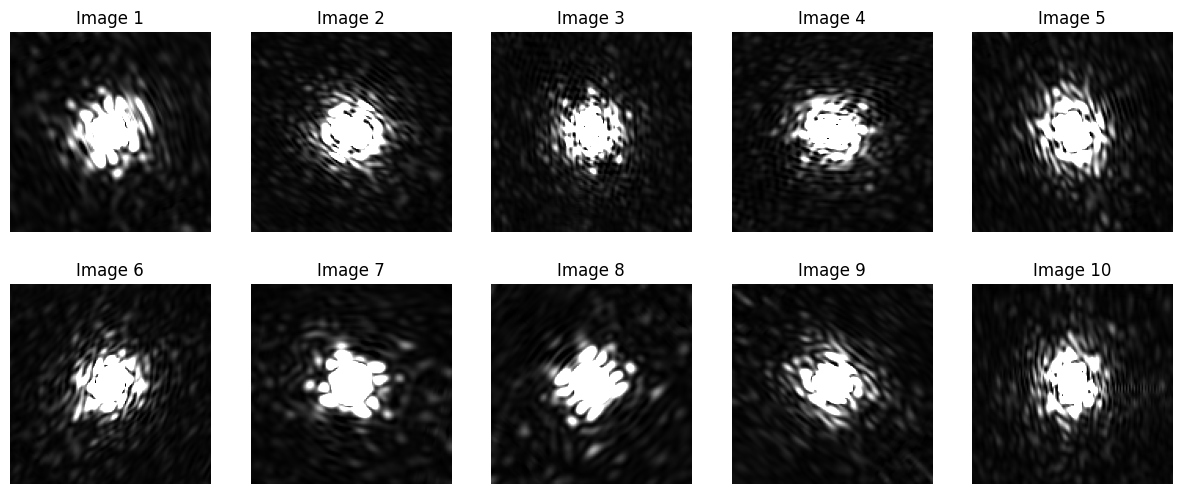

In [227]:
slices_nufft = nufft(ac, true_matrix[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

_rot_ac = rotate_volume(ac, matrix_to_quaternion(_opt_R)[None])[0]
# _rot_true_matrix = torch.einsum("ij, ljk -> lik", _opt_R.to(orientations), true_matrix)
_rot_true_matrix = torch.einsum("lij, kj -> lik", true_matrix, _opt_R.to(orientations))
slices_nufft = nufft(_rot_ac, _rot_true_matrix[test_idx[:10]])
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

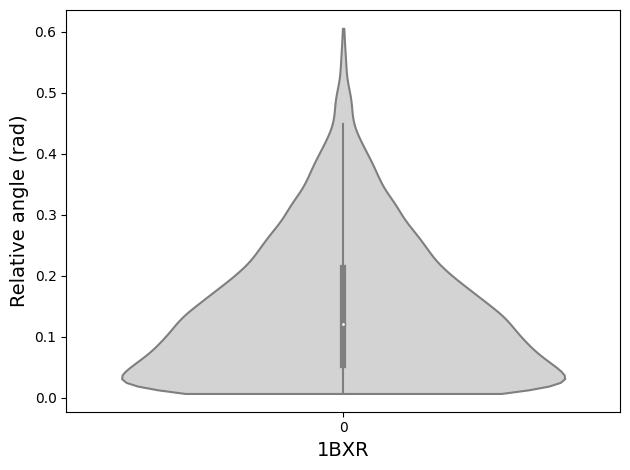

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Sample data: Replace this with your list of errors
# errors = np.random.normal(0, 1, 9000)
errors = relative_angles.min(dim=0).values.numpy()
# Compute the KDE for the errors
kde = gaussian_kde(errors)

# Evaluate the density for each error
densities = kde.evaluate(errors)
densities = densities / densities.max() * 0.4
x_coords = [np.random.uniform(-density, density) for density in densities]

fig, ax = plt.subplots(1,1)
# Create the violin plot
sns.violinplot(data=errors, color='lightgray', cut=0, ax=ax)

# Add scattered points on the violin plot
# sns.swarmplot(data=errors[:100], color='blue', size=2.5)
# sns.stripplot(data=errors, jitter=True, alpha=0.3, size=1)
# plt.scatter(x_coords, errors, color='blue', s=1, alpha=0.3)

# ax.set_title('Distribution of Errors', fontsize=14)
ax.set_xlabel(f'{pdb}', fontsize=14)
ax.set_ylabel('Relative angle (rad)', fontsize=14)
fig.tight_layout()
plt.show()


In [21]:
so3_relative_angle(rot_orientations, true_matrix)

tensor([1.5408, 1.3616, 3.0108,  ..., 1.8034, 3.0749, 1.5656])

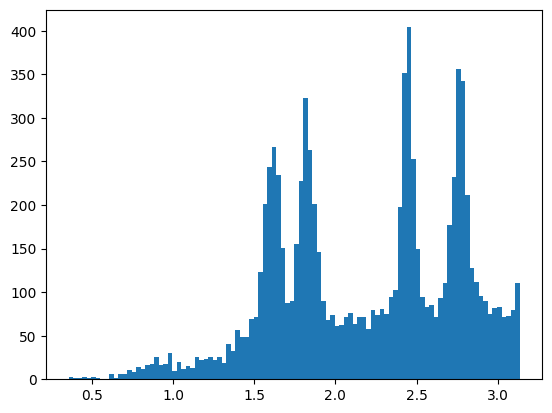

In [30]:
rel_ang = so3_relative_angle(rot_orientations, true_matrix)
plt.hist(rel_ang, bins=100);
rel_ang = torch.where(rel_ang > np.pi / 2, np.pi-rel_ang, rel_ang)

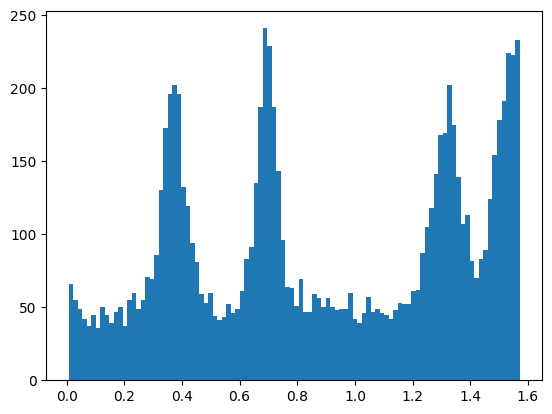

In [31]:
plt.hist(rel_ang, bins=100);

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

kmeans = KMeans(n_clusters=4).fit(rel_ang.numpy().reshape(-1,1))
labels = kmeans.labels_


/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


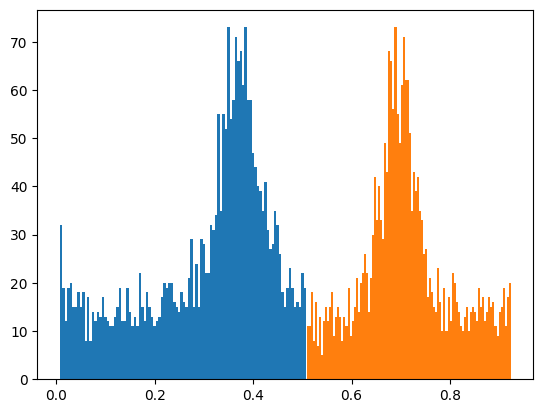

In [34]:
plt.hist(rel_ang[labels==0], bins=100);
# plt.hist(rel_ang[labels==1], bins=100);
plt.hist(rel_ang[labels==2], bins=100);
# plt.hist(rel_ang[labels==3], bins=100);

(0.0, 1.5707963267948966)

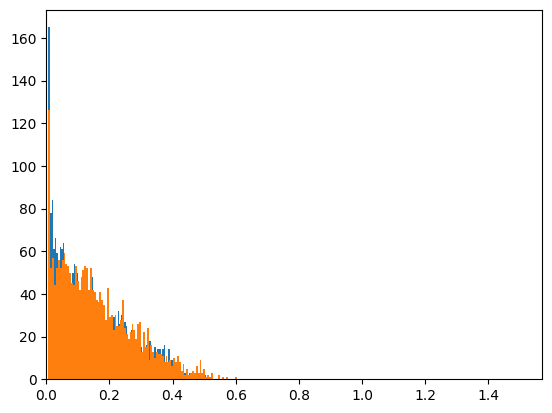

In [37]:
plt.hist(relative_angles.min(dim=0).values[labels==0], bins=100);
plt.hist(relative_angles.min(dim=0).values[labels==2], bins=100);
plt.xlim([0, np.pi/2])

In [122]:
R_rel = torch.einsum("lij, lkj -> lik", rot_orientations, true_matrix)
theta = so3_rotation_angle(R_rel)
# axis_ang = matrix_to_axis_angle(relative_rotmat)
# Compute the axis of rotation
n = torch.stack([
    R_rel[..., 2, 1] - R_rel[..., 1, 2],
    R_rel[..., 0, 2] - R_rel[..., 2, 0],
    R_rel[..., 1, 0] - R_rel[..., 0, 1]
], dim=-1)

n = n / (2 * torch.sin(theta).unsqueeze(-1))

In [106]:
so3_rotation_angle(relative_rotmat)

tensor([1.7968, 3.1309, 2.1476,  ..., 2.2192, 2.1611, 1.9351])

In [63]:
rel_rotmat_axis = axis_ang / axis_ang.norm(dim=1, keepdim=True)

In [70]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

kmeans = KMeans(n_clusters=4).fit(rel_rotmat_axis.numpy())
labels = kmeans.labels_


/pscratch/sd/z/zhantao/conda/om/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [142]:
mask = torch.where((rel_ang > 0.95) * (rel_ang < 1.05))[0]
mask = torch.where((rel_ang > 3.13))[0]

In [149]:
quaternion_grid = torch.from_numpy(sk.get_uniform_quat(100)).float()

In [150]:
axis_angle_grid = matrix_to_axis_angle(quaternion_to_matrix(quaternion_grid))

In [151]:
axis_angle_grid = axis_angle_grid / axis_angle_grid.norm(dim=1, keepdim=True)

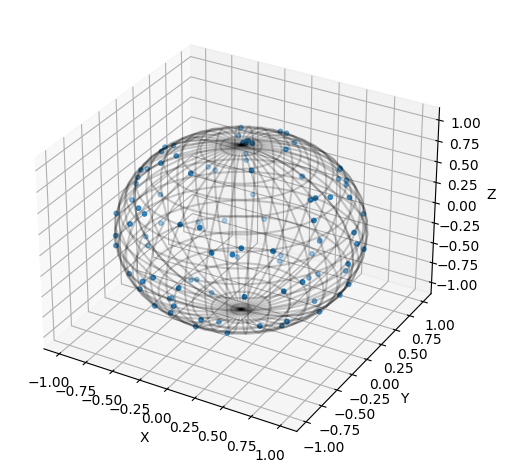

In [158]:
visualize_quaternions(sk.get_uniform_quat(100))

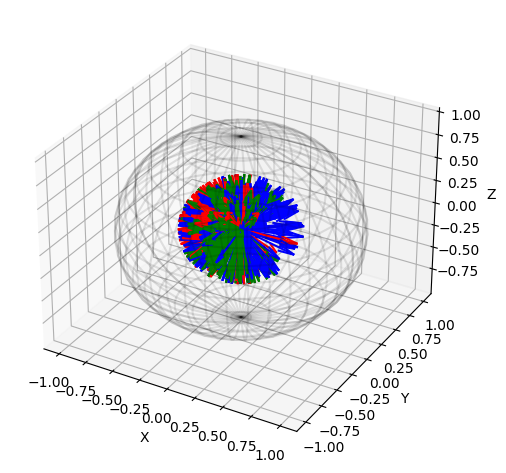

In [157]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_quaternions(quaternions, color=None):
    """
    Modified from: https://github.com/chuckie82/skopi/blob/main/skopi/geometry/generate.py#L225
    Visualize how given quaternions rotate the [0,0,1] unit vector on the surface
    of the unit sphere.
    
    :param quaternions: array of quaternions
    """
    from matplotlib import pyplot as plt
    
    # apply quaternions to [0,0,1] and convert to Cartesian coordinates
    coords = np.zeros((quaternions.shape[0], 3))
    for i in range(coords.shape[0]):
        theta, axis = sk.quaternion_to_angle_axis(quaternions[i])
        R = sk.angle_axis_to_rot3d(axis, theta)
        coords[i] = R.dot(np.array([0,0,1]))
    
    # generate latitutde/longitude lines along unit sphere
    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    x = np.outer(np.sin(theta), np.cos(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.cos(theta), np.ones_like(phi))

    # plot coordinates and unit sphere mesh
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'})
    ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1, alpha=0.2)
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], s=10, zorder=10, c=color)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    plt.tight_layout()
    plt.show()
    
    return

def plot_rotations(rot_matrices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Canonical basis vectors
    I = np.eye(3)
    
    colors = ['r', 'g', 'b']
    labels = ['x', 'y', 'z']
    # generate latitutde/longitude lines along unit sphere
    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    x = np.outer(np.sin(theta), np.cos(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.cos(theta), np.ones_like(phi))

    # plot coordinates and unit sphere mesh
    ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1, alpha=0.1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    for rot in rot_matrices:
        for idx, basis_vector in enumerate(I):
            transformed_vector = 0.5 * np.dot(rot, basis_vector)
            ax.quiver(0, 0, 0, transformed_vector[0], transformed_vector[1], transformed_vector[2], 
                      color=colors[idx], label=labels[idx] if 'x' in ax.get_legend_handles_labels()[1] else "")
    plt.tight_layout()

    # Ensure the axes are shown on the same scale
    # scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    # ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)

    # ax.legend()
    plt.show()

# # Example usage
# rot_matrices = [
#     [[0, -1, 0], [1, 0, 0], [0, 0, 1]],  # 90 degrees rotation about z-axis
#     [[0, 0, 1], [0, 1, 0], [-1, 0, 0]]   # 90 degrees rotation about y-axis
# ]

plot_rotations(relative_rotmat[mask])


In [94]:
relative_rotmat[labels==0].mean(dim=0, keepdim=True)

tensor([[[-0.1230,  0.0473,  0.1224],
         [-0.2275,  0.4237, -0.2153],
         [-0.0094, -0.5023, -0.0485]]])

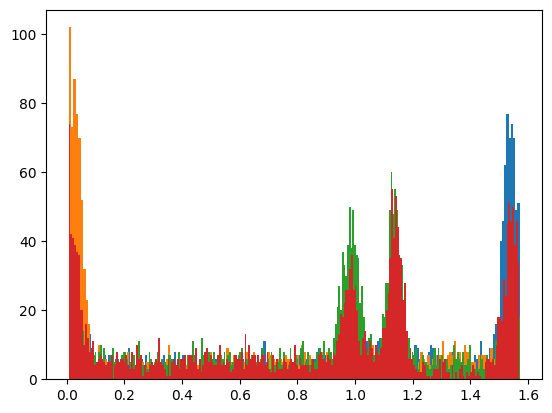

In [75]:
plt.hist(rel_ang[labels==0], bins=(labels==0).sum() // 10);
plt.hist(rel_ang[labels==1], bins=(labels==1).sum() // 10);
plt.hist(rel_ang[labels==2], bins=(labels==2).sum() // 10);
plt.hist(rel_ang[labels==3], bins=(labels==3).sum() // 10);

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [100]:
from pymatgen.symmetry.groups import PointGroup

In [106]:
[symm_op.rotation_matrix for symm_op in PointGroup('2/m').symmetry_ops]

[array([[ 1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  1.]]),
 array([[-1.,  0.,  0.],
        [ 0., -1.,  0.],
        [ 0.,  0., -1.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[-1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0., -1.]])]

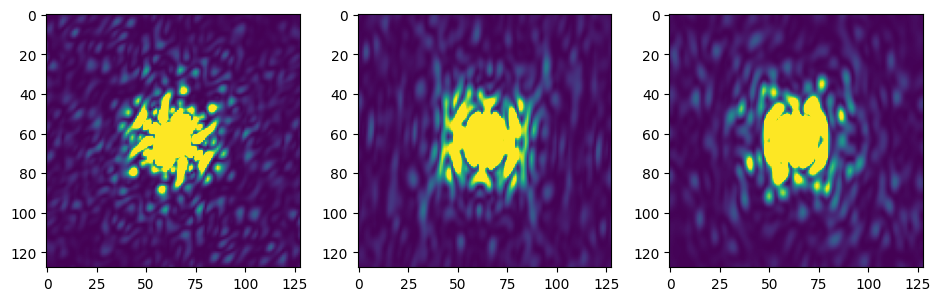

In [27]:
vol_recp_mesh = real_mesh_2_reciprocal_mesh(spi_data['vol_real_mesh']).cpu().numpy()
img_recp_mesh = real_mesh_2_reciprocal_mesh(spi_data['img_real_mesh']).cpu().numpy()

f_intensity = RegularGridInterpolator(
    [vol_recp_mesh[:,0,0,0], 
     vol_recp_mesh[0,:,0,1], 
     vol_recp_mesh[0,0,:,2]], 
    spi_data['volume'].abs().pow(2).cpu().numpy())
intensity = f_intensity(img_recp_mesh)
display_volumes(intensity, closefig=False, vmin=0, vmax=1e-3 * intensity.max())

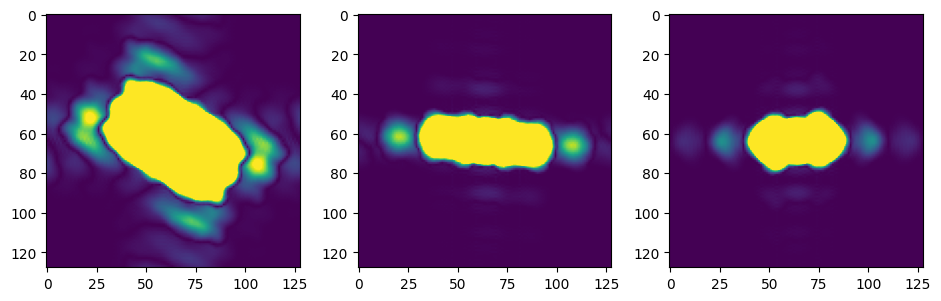

In [28]:
ac = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(torch.from_numpy(intensity))).abs())
display_volumes(ac, closefig=False, vmin=0, vmax=1e-2 * ac.max())

In [19]:
from neurorient.utils_transform import NUFFT

In [20]:
nufft = NUFFT(spi_data['pixel_position_reciprocal'], device=device)

In [21]:
slices_nufft = nufft(ac, orientations[:10])

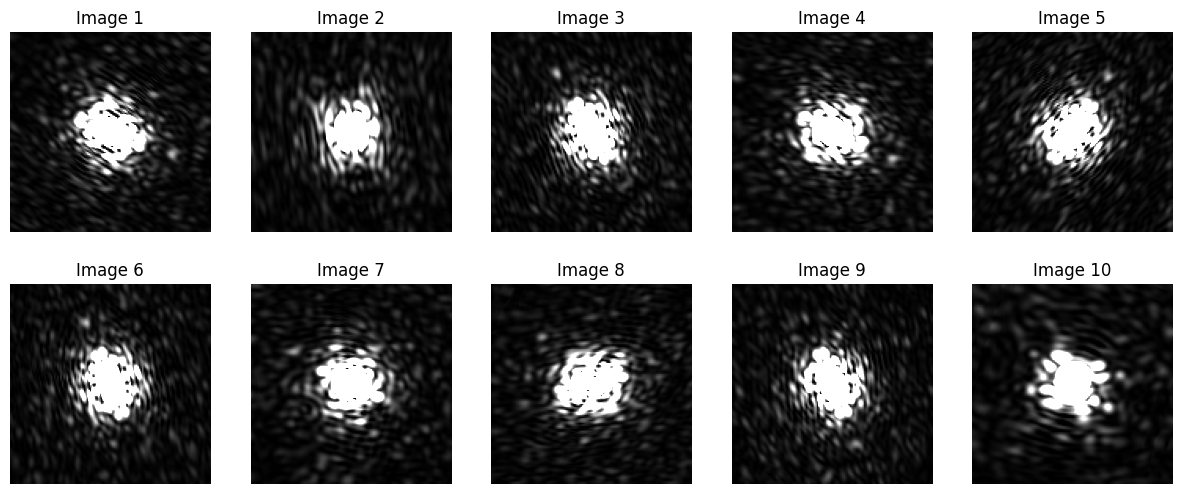

In [22]:
display_images(slices_nufft.clamp(0), columns=5, vmax=1e-3 * slices_nufft.max())

In [55]:
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import pdist, squareform

class QuaternionDataset(Dataset):
    def __init__(self, quaternions):
        self.quaternions = quaternions

    def __len__(self):
        return len(self.quaternions)

    def __getitem__(self, idx):
        quaternion = self.quaternions[idx]
        return quaternion, idx

In [56]:
quaternion_grid = torch.from_numpy(sk.get_uniform_quat(1000)).float()
slices_grid = torch.zeros(len(quaternion_grid), 128, 128)
quat_loader = DataLoader(QuaternionDataset(quaternion_grid), batch_size=100, shuffle=False)

for _quat in tqdm(quat_loader):
    slices_grid[_quat[1]] = nufft(ac, _quat[0]).cpu()
    # print(_quat)
    # break

100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


In [57]:
slices_grid = slices_grid.view(slices_grid.shape[0], -1)

In [65]:
slices_dist = squareform(pdist(slices_grid.cpu().numpy()))

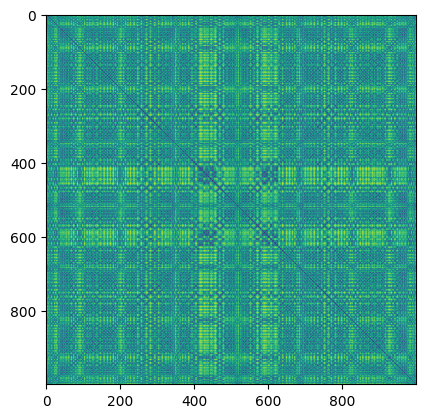

In [66]:
plt.imshow(slices_dist)

In [76]:
slices_sanitycheck = nufft(ac, quaternion_grid[slices_dist[1].argsort()[:3]]).cpu()

In [78]:
slices_dist[1].argsort()[:3]

array([  1, 520, 419])

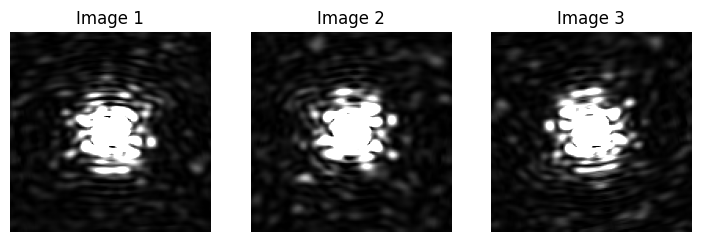

In [77]:
display_images(slices_sanitycheck.clamp(0), columns=5, vmax=1e-3 * slices_sanitycheck.max())